## 7.5 简单卷积网络实现迁移学习

#### 【例7-20】搭建简单的卷积网络。

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
num_classes = 5
filters = 32    #卷积核个数
pool_size = 2   #池化窗口大小
kernel_size = 3 #卷积核大小
img_rows,img_cols = 28,28
#输入数据形状为28x28x28x1
input_shape = (img_rows,img_cols,1)
#搭建特征提取层
feature_layers = [
    #搭建卷积层，输入参数；卷积核个数、卷积核大小、像素填充方式、输入数据
    Conv2D(filters,kernel_size,padding='valid',input_shape=input_shape),
    #激活函数选择Relu函数
    Activation('relu'),
    #搭建卷积层，输入参数：卷积核个数、卷积核大小
    Conv2D(filters,kernel_size),
    #激活函数选择Relu函数
    Activation('relu'),
    #搭建最大池化层
    MaxPooling2D(pool_size=pool_size),
    Dropout(0.25),
    #搭建平坦层
    Flatten(),
]
#搭建特征分类层
classification_layers = [
    #搭建全连接层，该层神经元个数为128
    Dense(128),
    #激活函数选择Relu函数
    Activation('relu'),
    Dropout(0.5),
    #搭建输出层，神经元个数为3
    Dense(num_classes),
    #激活函数选择Relu函数
    Activation('softmax'),
]
#采用序贯式创建模型model：将特征提取层与特征分类层组合在一起
model = Sequential(feature_layers + classification_layers)
#查看模型摘要
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_8 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_9 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)             

#### 【例7-21】将数据集分为两部分。

In [5]:
from keras.datasets import mnist
(X_train,Y_train),(X_test,Y_test) = mnist.load_data()
#MNIST数据集的标签为0~9,将标签0~4分为第1组，包括训练集和测试集
X_train_lt5 = X_train[Y_train < 5]
Y_train_lt5 = Y_train[Y_train < 5]
X_test_lt5 = X_test[Y_test < 5]
Y_test_lt5 = Y_test[Y_test < 5]
#将标签5~9分为第2组，包括训练集和测试集
X_train_gte5 = X_train[Y_train >= 5]
Y_train_gte5 = Y_train[Y_train >= 5] - 5
X_test_gte5  = X_test[Y_test >= 5]
Y_test_gte5  = Y_test[Y_test >= 5] - 5

#### 【例7-22】定义简单卷积网络模型的训练与测试集评估函数。

In [7]:
#导入to_categorical，为标签编码转换做准备
from keras.utils.np_utils import to_categorical
#导入时间模块
import datetime
#读取系统本地的时间
now  = datetime.datetime.now
batch_size = 128
num_classes = 5
epochs = 5
#定义训练函数，输入参数：模型、训练集、测试集、分类数目
def train_model(model,train,test,num_classes):
    #分别对训练数据和测试数据做形状变换
    X_train = train[0].reshape((train[0].shape[0],) + input_shape)
    X_test  = test[0].reshape((test[0].shape[0],) + input_shape)
    #分别对训练数据和测试数据做浮点型转换
    X_train = X_train.astype('float32')
    X_test  = X_test.astype('float32')
    #分别对训练数据和测试数据做归一化转换
    X_train /= 255
    X_test /= 255
    #打印训练数据形状
    print('X_train shape:',X_train.shape)
    #打印训练数据个数
    print(X_train.shape[0],'train samples')
    #打印测试数据个数
    print(X_test.shape[0],'test samples')
    #分别对训练标签和测试标签做one-hot编码转换
    Y_train = to_categorical(train[1],num_classes)
    Y_test = to_categorical(test[1],num_classes)
    #对模型进行编译
    model.compile(loss='categorical_crossentropy',
                 optimizer='adadelta',
                 metrics=['accuracy'])
    #对训练过程开始计时
    t = now()
    #对模型进行训练，训练过程存储在Training中
    Training = model.fit(X_train,Y_train,            #输入数据和标签
                         batch_size = batch_size,    #设置batch_size
                         epochs = epochs,
                         verbose=1,
                         validation_split=0.2
                        )
    #打印训练时间
    print('Training time：%s' % (now()-t))
    #用测试集评估网络模型
    score = model.evaluate(X_test,Y_test,verbose=0)
    #打印测试集评估的误差
    print('Test score：',score[0])
    #打印测试集评估的准确率
    print('Test accuracy：',score[1])
    #该函数返回值为Training训练过程，为后续绘制训练过程变化曲线做准备
    return Training

#### 【例7-23】对简单卷积网络模型进行训练。

In [8]:
#第1次调用train_model()函数，用第1组数据训练和评估网络模型，使特征提取层得到训练，第1次训练过程存储在history1中
history1 = train_model(model,(X_train_lt5,Y_train_lt5),(X_test_lt5,Y_test_lt5),num_classes)
#固定特征提取层的参数，使其不参与后续训练
for layer in feature_layers:
    layer.trainable = False
#再次查看网络模型
model.summary()
#第2次调用train_model()函数，用第2组数据训练和评估网络模型，使特征提取层得到训练，第2次训练过程存储在history中
history = train_model(model,(X_train_gte5,Y_train_gte5),(X_test_gte5,Y_test_gte5),num_classes)

X_train shape: (30596, 28, 28, 1)
30596 train samples
5139 test samples


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 24476 samples, validate on 6120 samples
Epoch 1/5





24476/24476 [==============================] - 20s 824us/step - loss: 0.1960 - acc: 0.9367 - val_loss: 0.0396 - val_acc: 0.9887
Epoch 2/5
24476/24476 [==============================] - 23s 960us/step - loss: 0.0538 - acc: 0.9842 - val_loss: 0.0246 - val_acc: 0.9928
Epoch 3/5
24476/24476 [==============================] - 30s 1ms/step - loss: 0.0372 - acc: 0.9884 - val_loss: 0.0219 - val_acc: 0.9935
Epoch 4/5
24476/24476 [==============================] - 27s 1ms/step - loss: 0.0289 - acc: 0.9915 - val_loss: 0.0266 - val_acc: 0.9922
Epoch 5/5
24476/24476 [==============================] - 28s 1ms/step - loss: 0.0243 - acc: 0.9932 - val_loss: 0.0186 - val_acc: 0.9940
Training time：0:02:09.648609
Test score： 0.007121006704571577
Test accuracy： 0.998054096127

C:\Users\LYJZB\Anaconda3\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 23523 samples, validate on 5881 samples
Epoch 1/5
23523/23523 [==============================] - 11s 478us/step - loss: 0.2566 - acc: 0.9243 - val_loss: 0.0690 - val_acc: 0.9799
Epoch 2/5
23523/23523 [==============================] - 12s 510us/step - loss: 0.0842 - acc: 0.9731 - val_loss: 0.0516 - val_acc: 0.9852
Epoch 3/5
23523/23523 [==============================] - 13s 533us/step - loss: 0.0611 - acc: 0.9803 - val_loss: 0.0502 - val_acc: 0.9855
Epoch 4/5
23523/23523 [==============================] - 11s 467us/step - loss: 0.0514 - acc: 0.9850 - val_loss: 0.0459 - val_acc: 0.9876
Epoch 5/5
23523/23523 [==============================] - 11s 468us/step - loss: 0.0445 - acc: 0.9865 - val_loss: 0.0440 - val_acc: 0.9874
Training time：0:00:58.223160
Test score： 0.02835665943248669
Test accuracy： 0.9903312074601025


#### 【例7-24】卷积网络模型可视化。

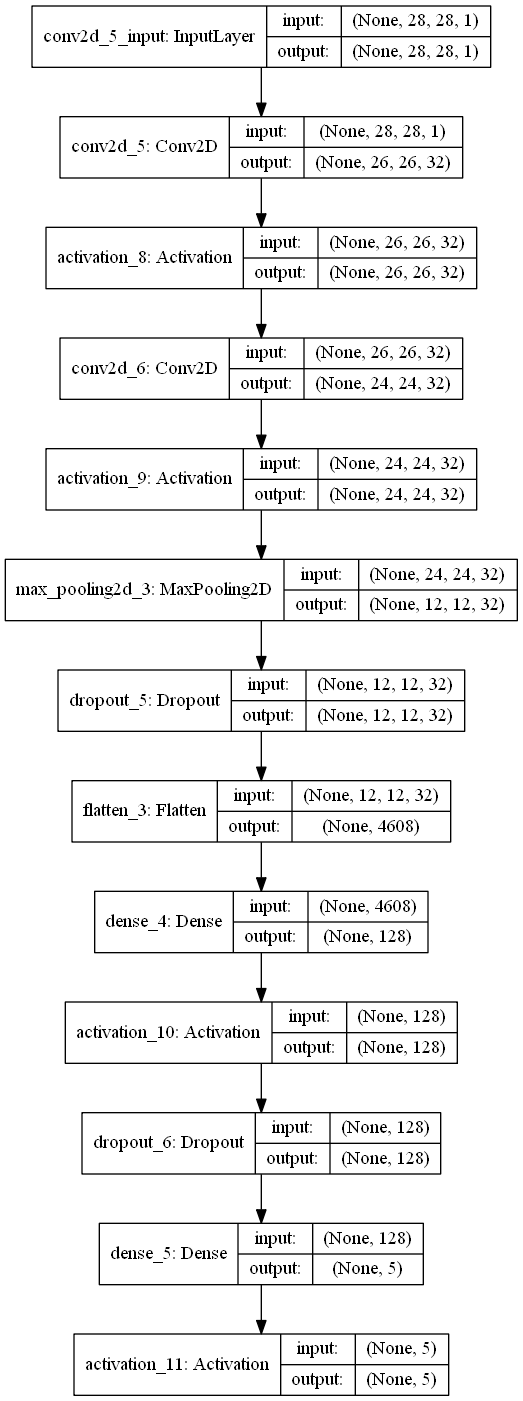

In [10]:
from keras.utils.vis_utils import plot_model
#调用plot_model函数，输入参数：网络模型、存储文件名称
plot_model(model=model,to_file='model_cnntransfer.png',show_shapes=True)

#### 【例7-25】画出卷积网络模型训练过程随迭代时期(epoch)变化曲线。

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

In [12]:
#定义绘制训练过程变化曲线函数
def plot_Training_history(history):
    #将训练过程的训练准确率赋值给acc
    acc = history.history['acc']
    #将训练过程的训练误差赋值给loss
    loss = history.history['loss']
    #将训练过程的验证准确率赋值给val_acc
    val_acc = history.history['val_acc']
    #将训练过程的验证误差赋值给val_loss
    val_loss = history.history['val_loss']
    #在同一坐标系啊画出训练准确率和验证准确率变化曲线图
    plt.plot(acc,linestyle='-',color='b',label='Training Acc.')
    plt.plot(val_acc,linestyle='--',color='r',label='Validation Acc.')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.ylabel('train')
    plt.xlabel('epoch')
    plt.show()
    #
    plt.plot(loss,linestyle='-',color='b',label='Training Loss')
    plt.plot(val_loss,linestyle='--',color='r',label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.ylabel('train')
    plt.xlabel('epoch')
    plt.show()

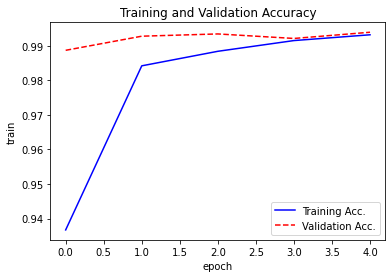

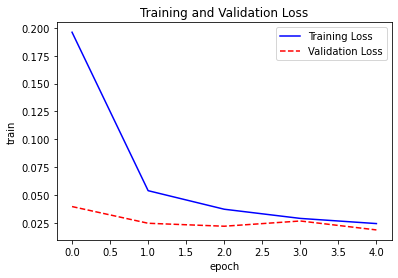

In [13]:
plot_Training_history(history1)

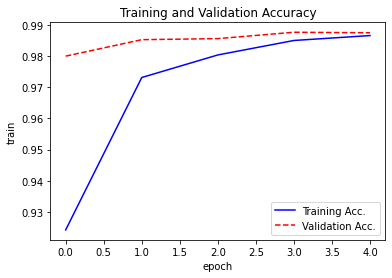

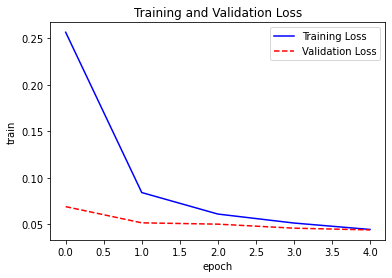

In [14]:
plot_Training_history(history)